In [1]:
import os.path
import datetime
from mlsettings.settings import load_app_config, get_datafolder_path
from mltools.modelbuilder.supervised  import SupervisedDataLoader 
from datatools.customtransformers import LogTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV 
import warnings
warnings.filterwarnings('ignore')
% matplotlib inline 
np.set_printoptions(precision=4)

pd.set_option('display.width', 200)
pd.set_option('precision', 4)
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
sns.set_style("whitegrid")
pd.options.display.float_format = '{:,.4f}'.format
sns.set()
import logging
logger = logging.getLogger()
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')
logger.setLevel(logging.DEBUG)


01-Jan-19 16:46:19 - DEBUG - backend module://ipykernel.pylab.backend_inline version unknown
01-Jan-19 16:46:19 - DEBUG - backend module://ipykernel.pylab.backend_inline version unknown


In [2]:
load_app_config()
DIRECTORY="AVLoanPrediction"
TRAIN_FILE  = "train.csv"
TEST_FILE  = "test.csv"
RESPONSE = "Loan_Status"
input_path = get_datafolder_path()
train_file = os.path.join(input_path, DIRECTORY, TRAIN_FILE)
test_file = os.path.join(input_path, DIRECTORY, TEST_FILE)
supervisedloader = SupervisedDataLoader(train_file=train_file,test_file=test_file,response =RESPONSE) 
train_dataset,test_dataset = supervisedloader.load()
supervisedloader.response

01-Jan-19 16:46:19 - INFO - Adding D:\DataSource to system path
01-Jan-19 16:46:19 - INFO - Adding D:\MachineLearning to system path
01-Jan-19 16:46:19 - INFO - Loading train_file :D:\DataSource\AVLoanPrediction\train.csv
01-Jan-19 16:46:19 - INFO - Loading test_file :D:\DataSource\AVLoanPrediction\test.csv


'Loan_Status'

In [3]:
train_dataset.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0000,nan,360.0000,1.0000,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,"1,508.0000",128.0000,360.0000,1.0000,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0000,66.0000,360.0000,1.0000,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,"2,358.0000",120.0000,360.0000,1.0000,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0000,141.0000,360.0000,1.0000,Urban,Y


In [4]:
train_dataset[supervisedloader.response].value_counts(normalize=True)
train_dataset['Total_Income'] = train_dataset['ApplicantIncome'] + train_dataset['CoapplicantIncome']
test_dataset['Total_Income'] = test_dataset['ApplicantIncome'] + test_dataset['CoapplicantIncome']

In [5]:
from mltools.mlhelper import missing_values
training_missing_values = missing_values(train_dataset)
all_missing  = training_missing_values[training_missing_values['Missing_Values'] ==train_dataset.shape[0]]
print("No of columns that have 100% missing values :{0}".format(all_missing.shape[0]))
all_missing.head()

No of columns that have 100% missing values :0


,Feature,Missing_Values,Percent_of_Total_Values


In [6]:
train_test = pd.concat([train_dataset,test_dataset],axis =0)
train_test.shape


(981, 14)

In [7]:
feature_count  = train_test.nunique(dropna=True)
feature_count

ApplicantIncome      752
CoapplicantIncome    437
Credit_History         2
Dependents             4
Education              2
Gender                 2
LoanAmount           232
Loan_Amount_Term      12
Loan_ID              981
Loan_Status            2
Married                2
Property_Area          3
Self_Employed          2
Total_Income         848
dtype: int64

In [8]:
categorical_ds = train_test.select_dtypes('object') 
categorical_columns = categorical_ds.columns.values.tolist() 
categorical_columns.remove('Loan_ID')
categorical_ds.describe()

,Dependents,Education,Gender,Loan_ID,Loan_Status,Married,Property_Area,Self_Employed
count,956,981,957,981,614,978,981,926
unique,4,2,2,981,2,2,3,2
top,0,Graduate,Male,LP002028,Y,Yes,Semiurban,No
freq,545,763,775,1,422,631,349,807


In [9]:
float_ds = train_test.select_dtypes(np.number)
float_columns = float_ds.columns.values.tolist()
float_ds.describe()

,ApplicantIncome,CoapplicantIncome,Credit_History,LoanAmount,Loan_Amount_Term,Total_Income
count,981.0000,981.0000,902.0000,954.0000,961.0000,981.0000
mean,"5,179.7951","1,601.9163",0.8359,142.5115,342.2019,"6,781.7114"
std,"5,695.1045","2,718.7728",0.3706,77.4217,65.1006,"6,023.9526"
min,0.0000,0.0000,0.0000,9.0000,6.0000,"1,442.0000"
25%,"2,875.0000",0.0000,1.0000,100.0000,360.0000,"4,166.0000"
50%,"3,800.0000","1,110.0000",1.0000,126.0000,360.0000,"5,314.0000"
75%,"5,516.0000","2,365.0000",1.0000,162.0000,360.0000,"7,308.0000"
max,"81,000.0000","41,667.0000",1.0000,700.0000,480.0000,"81,000.0000"


In [10]:
def get_nullframe(dataset):
    null_sum = dataset.isnull().sum()[dataset.isnull().sum()>0] 
    return pd.DataFrame({'feature':null_sum.index,'count':null_sum.values,
                          'null_percent':(null_sum.values/dataset.shape[0])*100}).sort_values(by=['count'],ascending=False)

In [11]:
null_count =get_nullframe(train_test)
null_count[null_count['feature']!=supervisedloader.response]

,feature,count,null_percent
0,Credit_History,79,8.0530
7,Self_Employed,55,5.6065
3,LoanAmount,27,2.7523
1,Dependents,25,2.5484
2,Gender,24,2.4465
4,Loan_Amount_Term,20,2.0387
6,Married,3,0.3058


01-Jan-19 16:46:20 - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=11.0 to Arial ('c:\\windows\\fonts\\arial.ttf') with score of 0.050000
01-Jan-19 16:46:21 - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to Arial ('c:\\windows\\fonts\\arial.ttf') with score of 0.050000


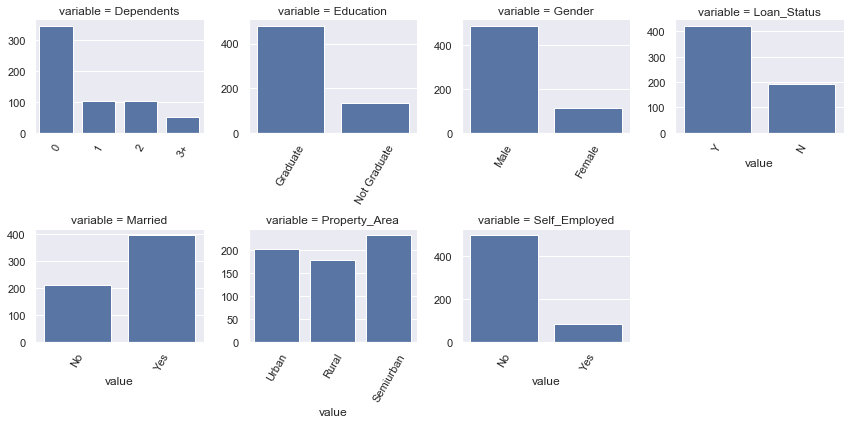

In [12]:
f = pd.melt(train_dataset, value_vars=sorted(categorical_columns))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
plt.xticks(rotation='vertical')
g = g.map(sns.countplot, 'value')
[plt.setp(ax.get_xticklabels(), rotation=60) for ax in g.axes.flat]
g.fig.tight_layout()
plt.show()

01-Jan-19 16:46:21 - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to Arial ('c:\\windows\\fonts\\arial.ttf') with score of 0.050000


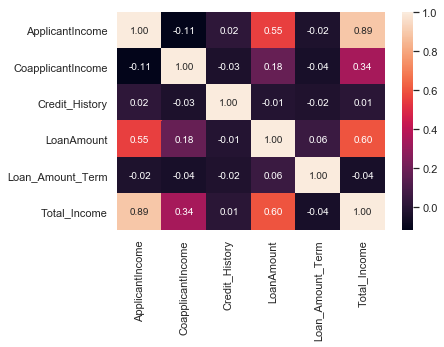

In [13]:
sns.heatmap(float_ds.corr(), annot=True, fmt=".2f")
plt.show()

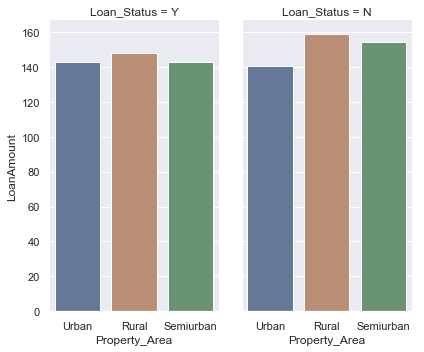

In [14]:
g = sns.catplot( x="Property_Area", y="LoanAmount", col="Loan_Status",
                 data=train_dataset, saturation=.5,
                 kind="bar", ci=None, aspect=.6)

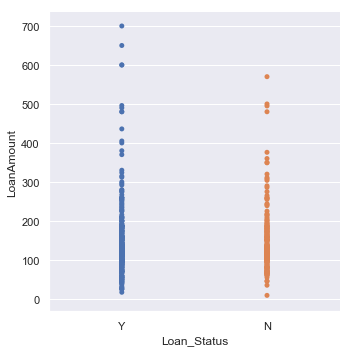

In [15]:
sns.catplot(x="Loan_Status", y="LoanAmount", jitter=False, data=train_dataset)

01-Jan-19 16:46:23 - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.2 to Arial ('c:\\windows\\fonts\\arial.ttf') with score of 0.050000


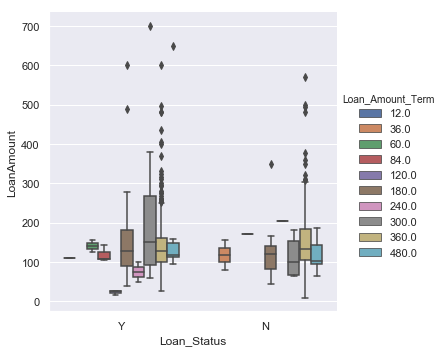

In [16]:
sns.catplot(x="Loan_Status", y="LoanAmount",hue='Loan_Amount_Term'  ,kind="box", data=train_dataset)

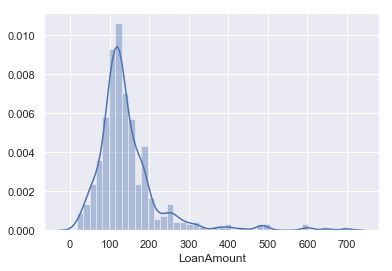

In [17]:
 ax = sns.distplot(train_dataset[(train_dataset['Loan_Status']=='Y')&(train_dataset['LoanAmount'].notnull())]['LoanAmount'])

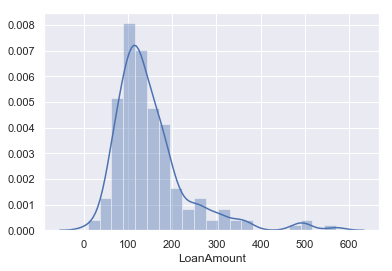

In [18]:
 ax = sns.distplot(train_dataset[(train_dataset['Loan_Status']=='N')&(train_dataset['LoanAmount'].notnull())]['LoanAmount'])

In [19]:
from mltools.mlhelper import missing_values
training_missing_values = missing_values(train_dataset)

In [20]:
training_missing_values

,Feature,Missing_Values,Percent_of_Total_Values
10,Credit_History,50,8.1400
5,Self_Employed,32,5.2100
8,LoanAmount,22,3.5800
3,Dependents,15,2.4400
9,Loan_Amount_Term,14,2.2800
1,Gender,13,2.1200
2,Married,3,0.4900


In [21]:
train_dataset['Missing_Count'] = train_dataset.isnull().sum(axis=1)

In [22]:
train_dataset[train_dataset['Missing_Count'] >=3]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income,Missing_Count
95,LP001326,Male,No,0,Graduate,NaN,6782,0.0000,nan,360.0000,nan,Urban,N,"6,782.0000",3
435,LP002393,Female,NaN,NaN,Graduate,No,10047,0.0000,nan,240.0000,1.0000,Semiurban,Y,"10,047.0000",3


In [23]:
test_dataset['Missing_Count'] = test_dataset.isnull().sum(axis=1)

In [24]:
test_dataset[test_dataset['Missing_Count'] >=2]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Total_Income,Missing_Count
45,LP001232,Male,Yes,0,Graduate,No,4260,3900,185.0000,nan,nan,Urban,8160,2
138,LP001769,NaN,No,NaN,Graduate,No,3333,1250,110.0000,360.0000,1.0000,Semiurban,4583,2
202,LP002111,Male,Yes,NaN,Graduate,No,3016,1300,100.0000,360.0000,nan,Urban,4316,2
247,LP002360,Male,Yes,NaN,Graduate,No,10000,0,nan,360.0000,1.0000,Urban,10000,2
259,LP002415,Female,No,1,Graduate,NaN,1850,4583,81.0000,360.0000,nan,Rural,6433,2
265,LP002441,Male,No,NaN,Graduate,No,3579,3308,138.0000,360.0000,nan,Semiurban,6887,2


In [25]:
train_dataset[train_dataset['Missing_Count'] >=2]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income,Missing_Count
19,LP001041,Male,Yes,0,Graduate,NaN,2600,"3,500.0000",115.0000,nan,1.0000,Urban,Y,"6,100.0000",2
24,LP001052,Male,Yes,1,Graduate,NaN,3717,"2,925.0000",151.0000,360.0000,nan,Semiurban,N,"6,642.0000",2
30,LP001091,Male,Yes,1,Graduate,NaN,4166,"3,369.0000",201.0000,360.0000,nan,Urban,N,"7,535.0000",2
95,LP001326,Male,No,0,Graduate,NaN,6782,0.0000,nan,360.0000,nan,Urban,N,"6,782.0000",3
102,LP001350,Male,Yes,NaN,Graduate,No,13650,0.0000,nan,360.0000,1.0000,Urban,Y,"13,650.0000",2
104,LP001357,Male,NaN,NaN,Graduate,No,3816,754.0000,160.0000,360.0000,1.0000,Urban,Y,"4,570.0000",2
228,LP001760,Male,NaN,NaN,Graduate,No,4758,0.0000,158.0000,480.0000,1.0000,Semiurban,Y,"4,758.0000",2
236,LP001786,Male,Yes,0,Graduate,NaN,5746,0.0000,255.0000,360.0000,nan,Urban,N,"5,746.0000",2
335,LP002106,Male,Yes,NaN,Graduate,Yes,5503,"4,490.0000",70.0000,nan,1.0000,Semiurban,Y,"9,993.0000",2
411,LP002319,Male,Yes,0,Graduate,NaN,6256,0.0000,160.0000,360.0000,nan,Urban,Y,"6,256.0000",2


In [26]:
train_dataset[(train_dataset['Credit_History'].isnull() ) & (train_dataset['LoanAmount'].isnull())]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income,Missing_Count
95,LP001326,Male,No,0,Graduate,NaN,6782,0.0000,nan,360.0000,nan,Urban,N,"6,782.0000",3


In [27]:
train_dataset[(train_dataset['Credit_History'].isnull() ) & (train_dataset['Loan_Status']=='Y')]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income,Missing_Count
16,LP001034,Male,No,1,Not Graduate,No,3596,0.0000,100.0000,240.0000,nan,Urban,Y,"3,596.0000",1
42,LP001123,Male,Yes,0,Graduate,No,2400,0.0000,75.0000,360.0000,nan,Urban,Y,"2,400.0000",1
79,LP001264,Male,Yes,3+,Not Graduate,Yes,3333,"2,166.0000",130.0000,360.0000,nan,Semiurban,Y,"5,499.0000",1
86,LP001280,Male,Yes,2,Not Graduate,No,3333,"2,000.0000",99.0000,360.0000,nan,Semiurban,Y,"5,333.0000",1
117,LP001405,Male,Yes,1,Graduate,No,2214,"1,398.0000",85.0000,360.0000,nan,Urban,Y,"3,612.0000",1
125,LP001443,Female,No,0,Graduate,No,3692,0.0000,93.0000,360.0000,nan,Rural,Y,"3,692.0000",1
130,LP001469,Male,No,0,Graduate,Yes,20166,0.0000,650.0000,480.0000,nan,Urban,Y,"20,166.0000",1
156,LP001541,Male,Yes,1,Graduate,No,6000,0.0000,160.0000,360.0000,nan,Rural,Y,"6,000.0000",1
187,LP001643,Male,Yes,0,Graduate,No,2383,"2,138.0000",58.0000,360.0000,nan,Rural,Y,"4,521.0000",1
198,LP001671,Female,Yes,0,Graduate,No,3416,"2,816.0000",113.0000,360.0000,nan,Semiurban,Y,"6,232.0000",1


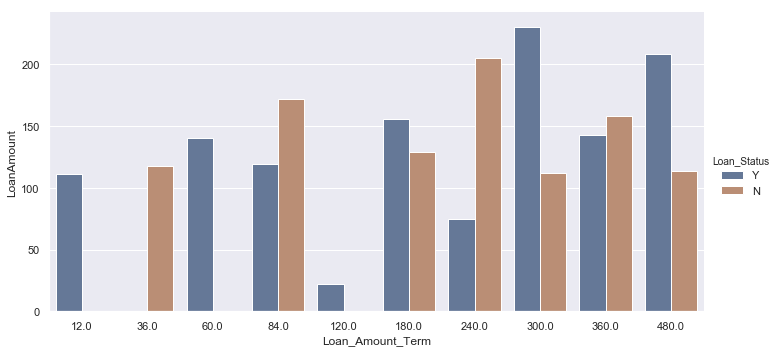

In [28]:
g = sns.catplot( x="Loan_Amount_Term", y="LoanAmount", hue ='Loan_Status' ,
                 data=train_dataset, saturation=.5,
                 kind="bar", ci=None, aspect=2)

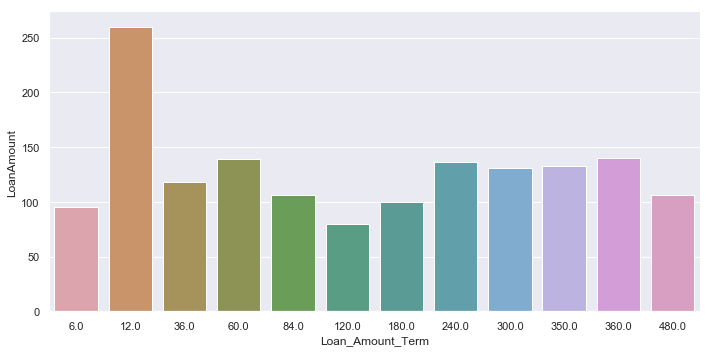

In [29]:
g = sns.catplot( x="Loan_Amount_Term", y="LoanAmount", 
                 data=test_dataset, saturation=.5,
                 kind="bar", ci=None, aspect=2)

In [ ]:
check

In [30]:
train_dataset['Credit_History'].fillna(train_dataset['Credit_History'].mode()[0], inplace=True)
test_dataset['Credit_History'].fillna(train_dataset['Credit_History'].mode()[0], inplace=True)
train_dataset['Self_Employed'].fillna(train_dataset['Self_Employed'].mode()[0], inplace=True)
test_dataset['Self_Employed'].fillna(train_dataset['Self_Employed'].mode()[0], inplace=True)

train_dataset['Dependents'].fillna(train_dataset['Dependents'].mode()[0],inplace=True)
test_dataset['Dependents'].fillna(train_dataset['Dependents'].mode()[0],inplace=True)

 
test_dataset['Loan_Amount_Term'].fillna(train_dataset['Loan_Amount_Term'].median(),inplace=True)
train_dataset['Loan_Amount_Term'].fillna(train_dataset['Loan_Amount_Term'].median(),inplace=True)
train_dataset['Gender'].fillna(train_dataset['Gender'].mode()[0], inplace=True)
test_dataset['Gender'].fillna(train_dataset['Gender'].mode()[0], inplace=True)

train_dataset['Married'].fillna(train_dataset['Gender'].mode()[0], inplace=True)
test_dataset['Married'].fillna(train_dataset['Gender'].mode()[0], inplace=True)

In [31]:
def emi_calculator(row): 
    r = 8.7 / (12 * 100) # one month interest 
    return (row['LoanAmount']*1000 * r * pow(1 + r, row['Loan_Amount_Term'])) / (pow(1 + r, row['Loan_Amount_Term']) - 1) 

table = train_dataset.pivot_table(values='LoanAmount', index='Self_Employed' ,columns='Education', aggfunc=np.median)

def fage(x):
     return table.loc[x['Self_Employed'],x['Education']]

# Replace missing values
train_dataset['LoanAmount'].fillna(train_dataset[train_dataset['LoanAmount'].isnull()].apply(fage, axis=1), inplace=True)
test_dataset['LoanAmount'].fillna(test_dataset[test_dataset['LoanAmount'].isnull()].apply(fage, axis=1), inplace=True)

In [32]:
#property_map = {'Rural':1,'Urban':2,'Semiurban':3}
train_dataset['TotalIncome'] =  train_dataset['ApplicantIncome']+ train_dataset['CoapplicantIncome']
train_dataset['HasCoApplicant'] = train_dataset['CoapplicantIncome'].apply(lambda x: "Y" if x > 0 else "N")
train_dataset['EMI'] = train_dataset.apply(emi_calculator,axis=1)
train_dataset['Balance_Income']= train_dataset['TotalIncome']-(train_dataset['EMI']) +1
train_dataset['Balance_ApplicantIncome']= train_dataset['ApplicantIncome']-(train_dataset['EMI']) +1
train_dataset['Married'] = (train_dataset['Married']=='Yes') * 1
train_dataset['Gender'] = (train_dataset['Gender']=='Male') * 1
#train_dataset['Property_Area'] = train_dataset['Property_Area'].map(property_map)
train_dataset['LoanAmount']= train_dataset['LoanAmount']

train_dataset['ApplicantIncomeRatio'] = train_dataset['ApplicantIncome']/ train_dataset['LoanAmount']
train_dataset['TotalIncomeRatio'] = train_dataset['TotalIncome']/ train_dataset['LoanAmount']
train_dataset['Dependents'].replace(('0', '1', '2', '3+'), (0, 1, 2, 3),inplace=True)

In [33]:
 corr_matrix = train_dataset.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [35]:
correlated_predictors ={}
correlation_threshold = 0.90
record_collinear = pd.DataFrame(columns = ['drop_feature', 'corr_feature', 'corr_value'])
for column in to_drop:
    co_related_features = list(upper.index[upper[column].abs() > correlation_threshold])
    co_related_values = list(upper[column][upper[column].abs() > correlation_threshold])
    drop_features = [column for _ in range(len(co_related_features))]  

    temp_df = pd.DataFrame.from_dict({'drop_feature': drop_features,
                                             'corr_feature': co_related_features,
                                             'corr_value': co_related_values})
    record_collinear = record_collinear.append(temp_df, ignore_index = True)
record_collinear.sort_values(by=['corr_value'],ascending=True)

,drop_feature,corr_feature,corr_value
3,Balance_ApplicantIncome,ApplicantIncome,0.9928
1,Balance_Income,Total_Income,0.9940
2,Balance_Income,TotalIncome,0.9940
0,TotalIncome,Total_Income,1.0000


In [36]:
encoding = train_dataset.groupby(['Married']).size()
encoding = encoding/len(train_dataset)
train_dataset['Married_Encoding'] = train_dataset['Married'].map(encoding)

In [37]:
train_dataset.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income,Missing_Count,TotalIncome,HasCoApplicant,EMI,Balance_Income,Balance_ApplicantIncome,ApplicantIncomeRatio,TotalIncomeRatio,Married_Encoding
0,LP001002,1,0,0,Graduate,No,5849,0.0000,130.0000,360.0000,1.0000,Urban,Y,"5,849.0000",1,"5,849.0000",N,"1,018.0717","4,831.9283","4,831.9283",44.9923,44.9923,0.3518
1,LP001003,1,1,1,Graduate,No,4583,"1,508.0000",128.0000,360.0000,1.0000,Rural,N,"6,091.0000",0,"6,091.0000",Y,"1,002.4090","5,089.5910","3,581.5910",35.8047,47.5859,0.6482
2,LP001005,1,1,0,Graduate,Yes,3000,0.0000,66.0000,360.0000,1.0000,Urban,Y,"3,000.0000",0,"3,000.0000",N,516.8672,"2,484.1328","2,484.1328",45.4545,45.4545,0.6482
3,LP001006,1,1,0,Not Graduate,No,2583,"2,358.0000",120.0000,360.0000,1.0000,Urban,Y,"4,941.0000",0,"4,941.0000",Y,939.7585,"4,002.2415","1,644.2415",21.5250,41.1750,0.6482
4,LP001008,1,0,0,Graduate,No,6000,0.0000,141.0000,360.0000,1.0000,Urban,Y,"6,000.0000",0,"6,000.0000",N,"1,104.2162","4,896.7838","4,896.7838",42.5532,42.5532,0.3518


In [38]:
#train_dataset.to_csv('Train_data.csv')